<a href="https://colab.research.google.com/github/WillKWL/Project-NBAGames/blob/master/source/3_playoff_games_test_set_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from google.colab import drive, files
import os
from joblib import load

import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
import copy
from datetime import datetime
from wordcloud import WordCloud

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
import sklearn
sklearn.set_config(display='diagram')

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-NBAGames')

Mounted at /content/drive


# Load environment
- load the following to evaluate model performance on test set:
  - custom clases,
  - functions, 
  - models dumped after hyperparameter tuning ,
  - test set

## Custom classes and functions
- data preparation pipeline before fitting estimator

In [3]:
# create a custom transformer to fix PFD by replacing it with OPP_PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    # print([x in X.columns for x in self.cols_drop])
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.QuantileTransformer.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names


# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [4]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None, best_silh = False):
    self.n_clusters = n_clusters
    self.random_state = random_state
    self.best_silh = best_silh
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    self.feature_names_in_ = X.columns.values
    self.index_names = X.sort_index().index.values
    
    # find best k number of clusters based on silhouette score
    if self.best_silh:
      # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
      # don't consider tuning k as hyperparameter because silhouette score is more intuitive
      # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
      k_range = np.arange(2,11,1)
      silh_scores = []
      for k in range(2,11):
        self.n_clusters = k
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        silh_scores.append(silhouette_score(X, self.kmeans_.labels_))
      
      max_k = k_range[np.argmax(silh_scores)]
      max_silh = max(silh_scores)
      self.n_clusters = max_k    

      # plot silhouette scores for 2 - 10 clusters
      if plot_silh:
        plt.plot(k_range, silh_scores)
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette score")
        plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
        plt.show()
    
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # Soft Clustering: each column = distance to cluster i
    X_clusterdist = pd.DataFrame(self.kmeans_.transform(X),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: Quantile transform the cluster distances like other numerical columns
    # X_clusterdist = pd.DataFrame(MyQuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_clusterdist),
    #                              columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: MinMaxScale transform the cluster distances like other numerical columns
    X_clusterdist = pd.DataFrame(MyMinMaxScaler().fit_transform(X_clusterdist),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # merge with numerical columns to return
    output = pd.concat([X, X_clusterdist], axis=1)
    self.output_features = output.columns.values
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

## Models after hyperparameter tuning

In [5]:
tuned_models = {}
time_list = []
time_diff = []
match_pattern = '_tuned_AP_playoff_games_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "playoff games AP loaded")

xgb playoff games AP loaded
xgbrf playoff games AP loaded
logistic playoff games AP loaded
svc playoff games AP loaded
sgd playoff games AP loaded


In [6]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  # tuned_AP.append(cross_val_score(model.best_estimator_, season, y_test, cv = 10, scoring='average_precision'))
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [7]:
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(AP) for AP in tuned_AP]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]

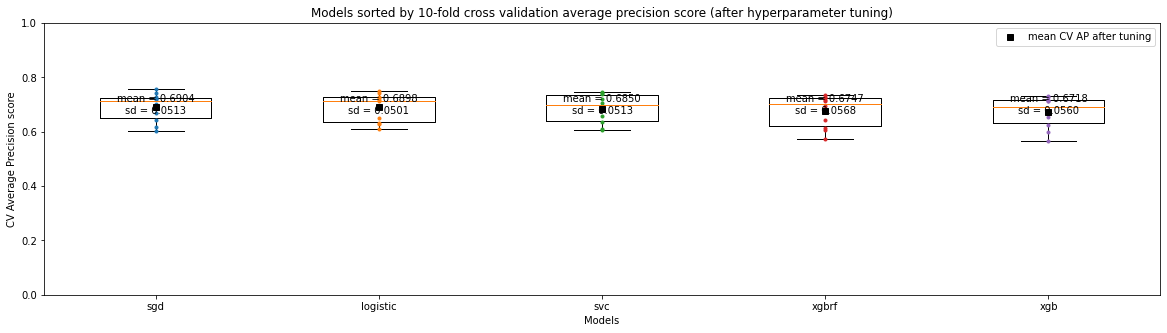

In [8]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation average precision score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV Average Precision score")
plt.show()

## Test set

In [9]:
test_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_games_test_comprehensive.pkl?raw=true")
# make a copy and split X and y
X_test = test_set.drop(columns = "OUTCOME").reset_index(drop = True).copy(deep = True)
y_test = test_set[["OUTCOME"]].values.reshape(-1,)

In [10]:
X_test.shape

(786, 194)

## Coefficients

Number of original features: 
194
Number of features after feature engineering, scaling and selection: 
60
Number of features after fitting estimator with regularization: 
38
features = ['HOME', 'OPP_FG3_PCT', 'OPP_FG3_PCT_OPP', 'PTS_OPP', 'OFF_RATING_OPP', 'PTS', 'OFF_RATING', 'FG_PCT_OPP', 'FG_PCT', 'OPP_FG_PCT', 'OPP_FG_PCT_OPP', 'PCT_PTS_OFF_TOV', 'PCT_PTS_OFF_TOV_OPP', 'PCT_PTS_PAINT_OPP', 'OPP_AST_OPP', 'OPP_PTS', 'OPP_AST', 'PTS_PAINT', 'OPP_PTS_OPP', 'OPP_REB', 'FT_PCT', 'DREB_PCT_OPP', 'OPP_BLK', 'BLKA', 'FT_PCT_OPP', 'OPP_BLK_OPP', 'BLKA_OPP', 'PTS_FB_OPP', 'PTS_FB', 'FTA_OPP', 'OPP_FTA', 'PF', 'OPP_PFD', 'OPP_FTA_OPP', 'OPP_STL_OPP', 'PCT_PTS_PAINT', 'PF_OPP', 'OPP_PFD_OPP']
coefficient = [1.0388, -0.8222, 0.7886, -0.7386, -0.7386, 0.6861, 0.6861, -0.6586, 0.5295, -0.4749, 0.4513, -0.4021, 0.3908, -0.3611, 0.3537, -0.3433, -0.3384, 0.3187, 0.3178, -0.3006, -0.1896, -0.1632, -0.1594, -0.1594, 0.158, 0.1546, 0.1546, -0.1527, 0.1374, -0.1084, -0.1083, -0.1055, -0.1055, 0.1023, 

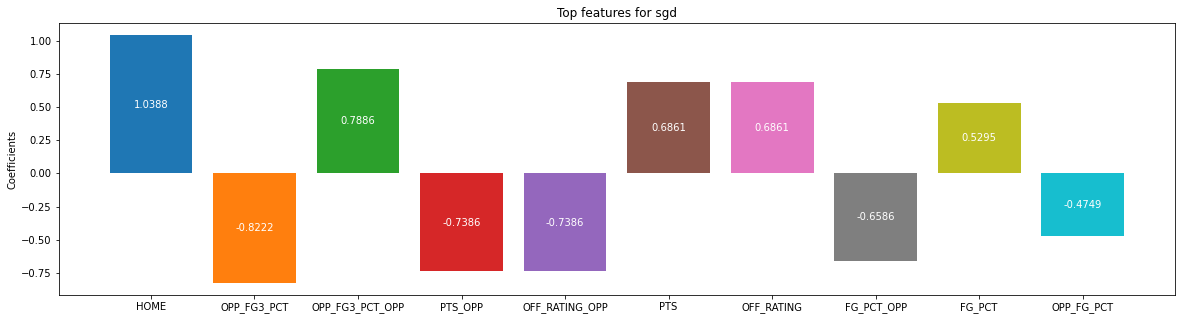

Number of original features: 
194
Number of features after feature engineering, scaling and selection: 
60
Number of features after fitting estimator with regularization: 
19
features = ['HOME', 'FG_PCT_OPP', 'FG_PCT', 'OPP_FG3_PCT_OPP', 'OPP_FG3_PCT', 'PTS', 'OFF_RATING', 'PTS_OPP', 'OFF_RATING_OPP', 'OPP_FG_PCT_OPP', 'OPP_FG_PCT', 'OPP_AST_OPP', 'OPP_AST', 'OPP_BLK_OPP', 'BLKA_OPP', 'OPP_BLK', 'BLKA', 'PF', 'OPP_PFD']
coefficient = [0.9793, -0.7418, 0.7383, 0.4964, -0.4865, 0.4772, 0.4772, -0.4717, -0.4717, 0.4419, -0.4372, 0.1767, -0.1748, 0.0206, 0.0206, -0.0184, -0.0184, -0.0007, -0.0007]


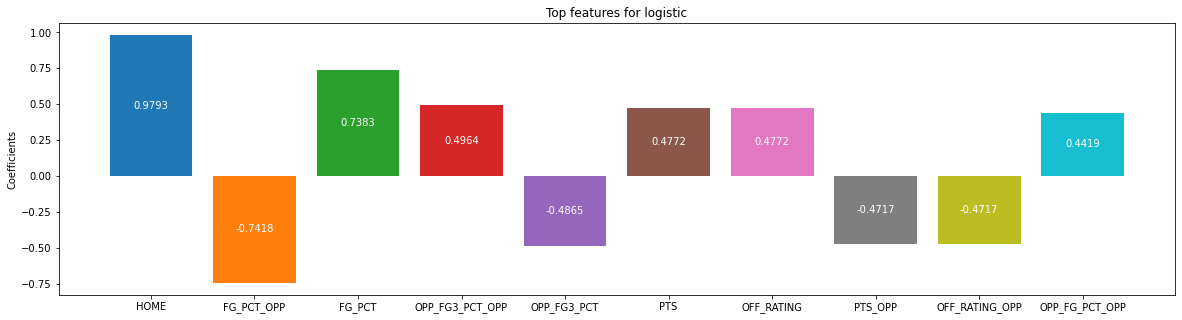

Number of original features: 
194
Number of features after feature engineering, scaling and selection: 
59
Number of features after fitting estimator with regularization: 
59
features = ['HOME', 'OPP_FG3_PCT', 'OPP_FG3_PCT_OPP', 'PTS_OPP', 'OFF_RATING_OPP', 'PTS', 'OFF_RATING', 'OPP_AST_OPP', 'PCT_PTS_OFF_TOV_OPP', 'PCT_PTS_OFF_TOV', 'OPP_AST', 'OPP_FG_PCT_OPP', 'OPP_FG_PCT', 'OPP_PTS', 'FG_PCT_OPP', 'PCT_PTS_PAINT_OPP', 'FG_PCT', 'PTS_PAINT', 'OPP_PTS_OPP', 'STL_OPP', 'OPP_REB', 'OPP_BLK', 'BLKA', 'FT_PCT', 'PTS_FB_OPP', 'FT_PCT_OPP', 'OPP_STL_OPP', 'OPP_BLK_OPP', 'BLKA_OPP', 'OPP_STL', 'PACE_OPP', 'OPP_OREB_OPP', 'STL', 'PTS_2ND_CHANCE', 'FTA_OPP', 'PTS_FB', 'PCT_AST_FGM', 'OPP_OREB', 'PACE', 'PTS_2ND_CHANCE_OPP', 'PCT_PTS_PAINT', 'DREB_PCT_OPP', 'OREB_OPP', 'OPP_FTA_OPP', 'FG3_PCT', 'OPP_FTA', 'OPP_BLKA_OPP', 'BLK_OPP', 'PF_OPP', 'OPP_PFD_OPP', 'OREB', 'PF', 'OPP_PFD', 'PCT_UAST_FGM_OPP', 'OPP_BLKA', 'BLK', 'FG3_PCT_OPP', 'AST_TO', 'AST_TO_OPP']
coefficient = [1.8516, -0.1812, 0.171

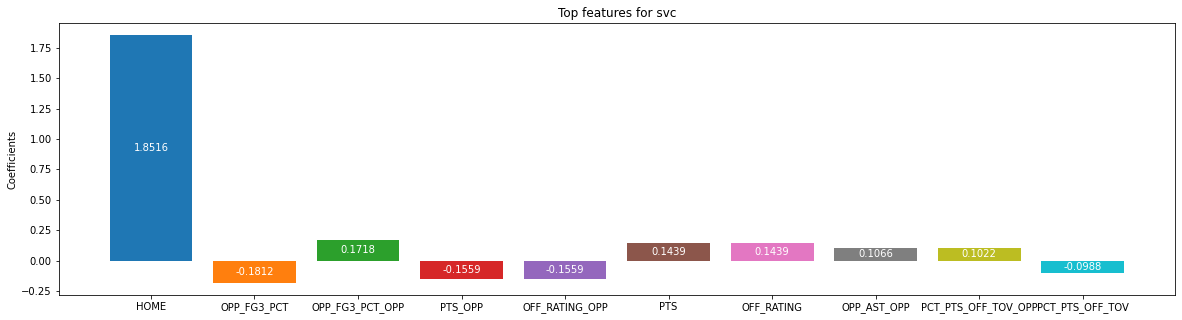

Number of original features: 
194
Number of features after feature engineering, scaling and selection: 
59
Number of features after fitting estimator with regularization: 
56
features = ['HOME', 'OPP_BLKA_OPP', 'FG_PCT_OPP', 'FG_PCT', 'OFF_RATING', 'PTS', 'PTS_OPP', 'FG3_PCT_OPP', 'OFF_RATING_OPP', 'OREB', 'OPP_FG_PCT_OPP', 'OPP_FG_PCT', 'OPP_AST', 'OPP_AST_OPP', 'PCT_PTS_OFF_TOV', 'PF_OPP', 'PF', 'PCT_PTS_OFF_TOV_OPP', 'OPP_PTS', 'PTS_PAINT', 'OPP_BLK_OPP', 'BLKA_OPP', 'BLKA', 'PCT_AST_FGM', 'OPP_PTS_OPP', 'BLK', 'OPP_FG3_PCT_OPP', 'OPP_REB', 'OPP_FG3_PCT', 'FG3_PCT', 'BLK_OPP', 'OPP_PFD', 'OPP_BLK', 'PCT_UAST_FGM_OPP', 'AST_TO_OPP', 'PTS_FB_OPP', 'AST_TO', 'PTS_2ND_CHANCE_OPP', 'PACE', 'PTS_FB', 'DREB_PCT_OPP', 'OREB_OPP', 'OPP_OREB', 'STL', 'PCT_PTS_PAINT_OPP', 'STL_OPP', 'PACE_OPP', 'OPP_STL_OPP', 'FT_PCT', 'PCT_PTS_PAINT', 'FT_PCT_OPP', 'OPP_FTA_OPP', 'OPP_STL', 'OPP_FTA', 'OPP_OREB_OPP', 'FTA_OPP']
coefficient = [0.178, 0.0273, 0.0265, 0.0263, 0.0254, 0.0245, 0.024, 0.0219, 0.021

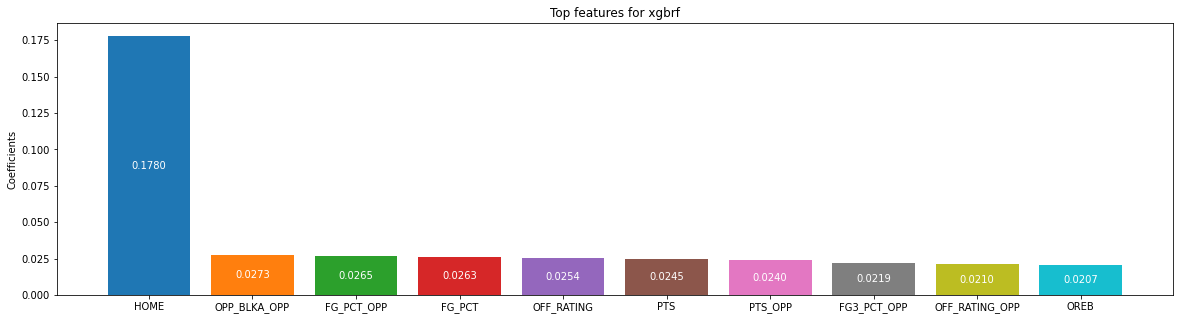

Number of original features: 
194
Number of features after feature engineering, scaling and selection: 
60
Number of features after fitting estimator with regularization: 
51
features = ['HOME', 'FG_PCT', 'FG_PCT_OPP', 'STL_OPP', 'PTS_OPP', 'PTS', 'OPP_PTS', 'OPP_FG_PCT', 'OPP_FG_PCT_OPP', 'OPP_PTS_OPP', 'STL', 'OPP_AST_OPP', 'OPP_AST', 'OPP_STL_OPP', 'OPP_FG3_PCT_OPP', 'FG3_PCT', 'PTS_PAINT', 'OPP_REB', 'OPP_FG3_PCT', 'FT_PCT', 'FT_PCT_OPP', 'BLKA', 'BLKA_OPP', 'PCT_PTS_OFF_TOV_OPP', 'AST_TO_OPP', 'PTS_2ND_CHANCE', 'PF_OPP', 'BLK', 'PTS_FB_OPP', 'PACE_OPP', 'OPP_OREB', 'BLK_OPP', 'FG3_PCT_OPP', 'PF', 'PCT_PTS_OFF_TOV', 'AST_TO', 'PCT_PTS_PAINT_OPP', 'OREB_OPP', 'PTS_2ND_CHANCE_OPP', 'PACE', 'PTS_FB', 'PCT_PTS_PAINT', 'OPP_FTA_OPP', 'PCT_UAST_FGM_OPP', 'OPP_FTA', 'FTA_OPP', 'OPP_STL', 'OREB', 'OPP_OREB_OPP', 'AST_PCT', 'DREB_PCT_OPP']
coefficient = [0.144, 0.031, 0.0286, 0.0264, 0.025, 0.025, 0.0242, 0.024, 0.0231, 0.0226, 0.0223, 0.0212, 0.0196, 0.0187, 0.0187, 0.0184, 0.0182, 0.018, 

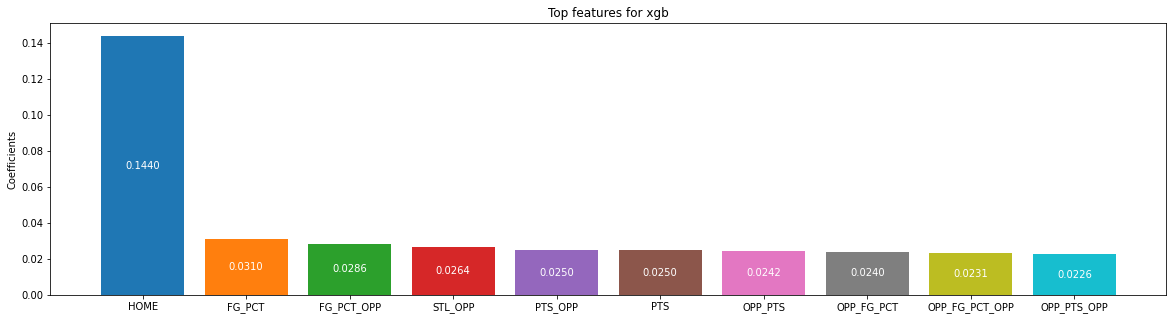

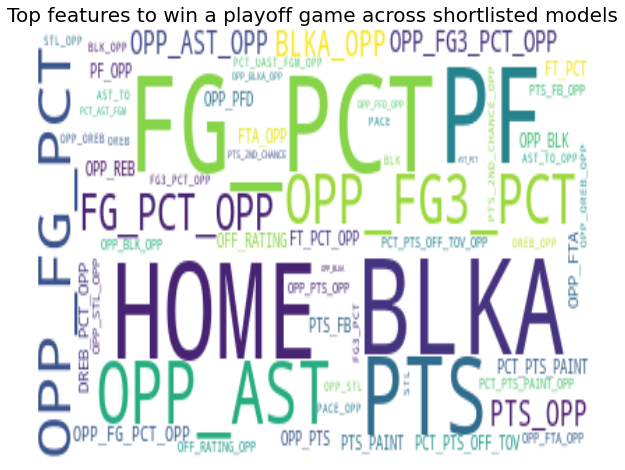

In [11]:
coef_list = []
for model_name in sorted_tuned_clf:
  chosen_model = tuned_models[model_name].best_estimator_
  
  # original features
  features_in = X_test.columns.values # cannot use features_in here since data_cleaning pipeline is wrapped in SeasonSimilarity instead of part of data_preparation pipeline
  print(f"Number of original features: \n{len(X_test.columns.values)}")
  # print(features_in, "\n")

  # sparse features after feature selection with L1 penalty in data_preparation pipeline
  features_out = chosen_model[:-1].get_feature_names_out() 
  print(f"Number of features after feature engineering, scaling and selection: \n{len(features_out)}")
  # print(features_out, "\n")

  # non-zero (signficant) features after regularization in fitting estimator
  try:
    coef = chosen_model.steps[-1][1].feature_importances_
  except:
    coef = chosen_model.steps[-1][1].coef_[0]
  print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
  features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
  coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
  print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
  print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

  abs_coef = np.abs(coef)
  fig, ax = plt.subplots(1,1)
  top_n = 10
  for i, (_, coef, name) in enumerate(sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]):
    ax.bar(name, coef)
  for rect in ax.patches:
      height = rect.get_height()
      ax.annotate(f"{height:0.4f}",
                  xy=(rect.get_x() + rect.get_width() / 2, height/2),
                  xytext=(0, 0),  # 3 points vertical offset
                  textcoords="offset points",
                  color = 'white',
                  ha='center', va='center')
  plt.title(f"Top features for {model_name}")
  plt.ylabel("Coefficients")
  plt.show()
  coef_list.extend(features_non_zero)

wc = WordCloud(background_color="white", collocations=False)
# generate word cloud
plt.figure(figsize=(10, 8))
wc.generate(" ".join(i for i in coef_list))

# show
plt.imshow(wc, interpolation="bilinear", aspect='auto')
plt.title("Top features to win a playoff game across shortlisted models", fontsize=20)
plt.axis("off")
plt.show()

## Pick best model

In [12]:
best_model = tuned_models['sgd'].best_estimator_

In [13]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fixpf-1',
                                                                   FixPF(col_drop='PFD',
                                                                         col_replace='OPP_PF')),
                                                                  ('fixpf-2',
                                                                   FixPF(col_drop='PFD_OPP',
                                                                         col_replace='OPP_PF_OPP')),
                                                                  ('dropcols',
                                                                   DropCols(cols_drop=['GP',
                                                                                       'W',
                                                                                       'L',
                                                                                       'W_PCT',
                                                                                       'PFD',
                                                                                       'MIN',
                                                                                       'FGM',
                                                                                       'FG3M',
                                                                                       'FTM',
                                                                                       'OPP_FGM',
                                                                                       'OPP_FG3M',
                                                                                       'OPP_FTM',
                                                                                       'TM_TOV_PCT',
                                                                                       'REB',
                                                                                       'REB_P...
                                   verbose_feature_names_out=False)),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'),
                                 threshold=0.00026558434508499874)),
                ('sgd',
                 SGDClassifier(alpha=0.0011851515660043107,
                               eta0=0.016562605893335948,
                               l1_ratio=0.5026790232288615,
                               learning_rate='adaptive', loss='log',
                               penalty='elasticnet', random_state=42))])

## Predicted Probabilities

In [14]:
# prediction
y_probs = best_model.predict_proba(X_test)[:,1]

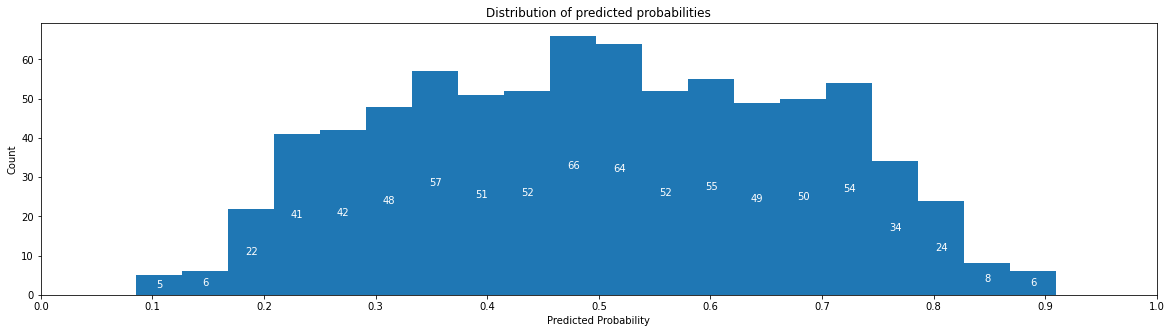

In [15]:
fig, ax = plt.subplots(1,1)
ax.hist(y_probs, bins = 20)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.0f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

# Performance evaluation

## Precision-Recall curve
- Prefer precision-recall over ROC curve
- Precision > Recall
  - As a team manager or as a fan, precision of the prediction matters more than recall

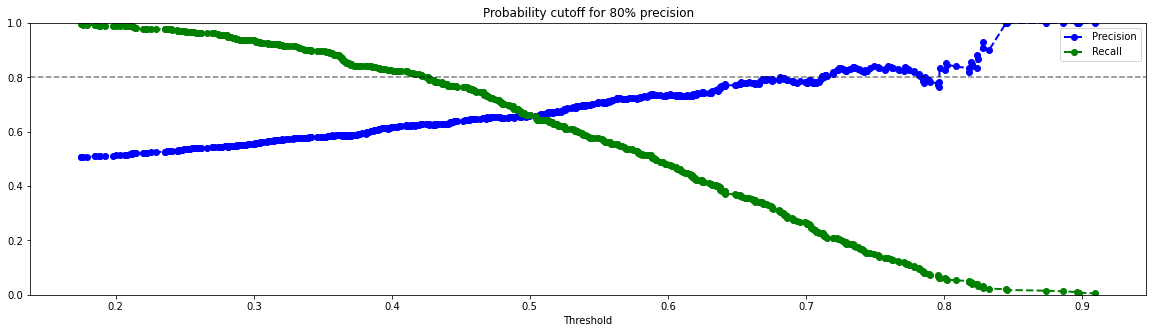

In [16]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.axhline(0.8, ls='--', c='k', alpha=0.5)
plt.title("Probability cutoff for 80% precision")
plt.legend()
plt.show()

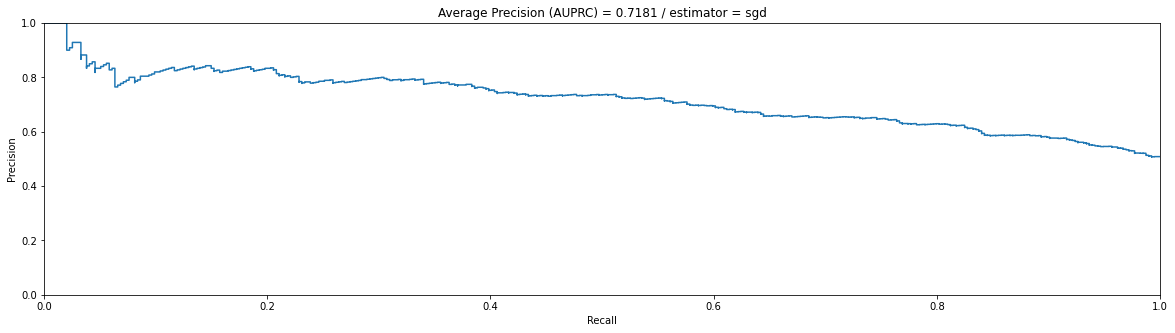

In [17]:
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"Average Precision (AUPRC) = {average_precision_score(y_test, y_probs):0.4f} / estimator = {best_model.steps[-1][0]}")
plt.show()

## Average Precision
- Average precision = area under precision-recall curve
  - [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

In [18]:
CV_model = tuned_models[best_model.steps[-1][0]]
cv_result = pd.DataFrame(CV_model.cv_results_)
cv_AP_colindex = [i for i, x in enumerate(cv_result.columns.values) if re.search('split\w+_test_score', x) is not None]
best_CV_AP = pd.DataFrame(CV_model.cv_results_).iloc[CV_model.best_index_,cv_AP_colindex].values

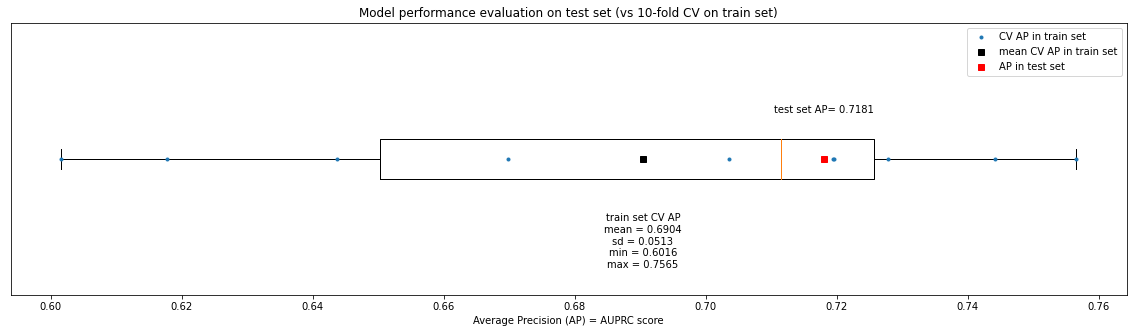

In [20]:
# plot CV AP scores on train set
plt.boxplot(best_CV_AP, labels = [""], vert=False)
plt.plot(best_CV_AP, [1]*len(best_CV_AP), ".", label='CV AP in train set')
plt.annotate(f"train set CV AP\n" + 
             f"mean = {np.mean(best_CV_AP):0.4f}\n" + 
             f"sd = {np.std(best_CV_AP):0.4f}\n" + 
             f"min = {np.min(best_CV_AP):0.4f}\n" + 
             f"max = {np.max(best_CV_AP):0.4f}",
             (np.mean(best_CV_AP), 0.8), 
              ha = 'center', va = 'top')
plt.plot(np.mean(best_CV_AP), [1], "ks", label = 'mean CV AP in train set')

# compare with AP score on test set
test_AP = average_precision_score(y_test, y_probs)
plt.plot(test_AP, [1], "rs", label = 'AP in test set')
plt.annotate(f"test set AP= {test_AP:0.4f}",(test_AP, 1.2), 
              ha = 'center', va = 'top')

plt.legend()
plt.title(f"Model performance evaluation on test set (vs 10-fold CV on train set)")
plt.xlabel("Average Precision (AP) = AUPRC score")
# plt.xlim(0.5,1)
plt.ylabel("")
plt.yticks([])
plt.show()

## Lift and gain chart

In [21]:
temp_df = pd.DataFrame({
    'y': y_test,
    'prob': y_probs
})
temp_df.sort_values('prob', ascending=False, inplace=True)
temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])

In [22]:
lift_n_gain = temp_df.groupby('decile').agg({'y': ['sum']}).sort_index(ascending=False)
lift_n_gain.columns = ['sum_of_positive_cases_identified']
lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / 10)

In [23]:
lift_n_gain

,sum_of_positive_cases_identified,gain,lift
decile,,,
1,65,0.164975,1.649746
2,58,0.312183,1.560914
3,50,0.439086,1.463621
4,49,0.563452,1.408629
5,37,0.657360,1.314721
6,42,0.763959,1.273266
7,30,0.840102,1.200145
8,30,0.916244,1.145305
9,20,0.967005,1.074450


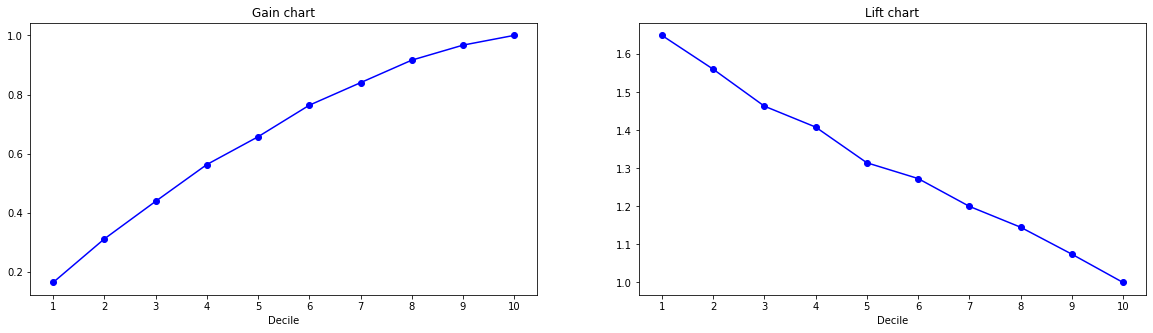

In [24]:
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(1,11,1), lift_n_gain['gain'].values, 'bo-')
axes[1].plot(np.arange(1,11,1), lift_n_gain['lift'].values, 'bo-')
axes[0].set_title('Gain chart')
axes[1].set_title('Lift chart')
for ax in axes:
  ax.set_xticks(np.arange(1,11,1))
  ax.set_xlabel("Decile")
plt.show()

## Confusion matrix

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
# to achieve a precision of 80% or more
precision_pct = 0.8

In [ ]:
# due to class imbalance in a small test set, 
# the threshold intervals are so sparse that it becomes hard to achieve exactly 80%
idx_for_chosen_precision = (precisions >= precision_pct).argmax()
chosen_threshold = thresholds[idx_for_chosen_precision]
y_predict = (best_model.predict_proba(X_test)[:,1] >= chosen_threshold)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.57      0.92      0.70       392
           1       0.80      0.30      0.44       394

    accuracy                           0.61       786
   macro avg       0.68      0.61      0.57       786
weighted avg       0.68      0.61      0.57       786



In [ ]:
# only 1 instance was predicted and correctly identified as positive (winning a championship)
confusion_matrix(y_test, y_predict)

array([[362,  30],
       [274, 120]])

## ROC curve and AUC score
- ROC AUC score is high but it is overly optimistic given it replaces precision in precision-recall curve with False Positive Rate
- With class imbalance in our dataset, the importance of True Negatives is exaggerated in ROC AUC curve

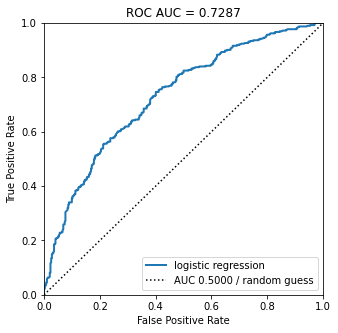

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth = 2, label = f"logistic regression")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"ROC AUC = {roc_auc_score(y_test, y_probs):0.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()

# Performance evaluation - playoff ranking

In [ ]:
# Given a certain threshold, we will be able to achieve a certain level of precision and recall in predicting outcome (Win/Lose) of playoff games
# Based on that prediction, we can arrive at the precision and recall in predicting playoff ranking
def playoff_ranking_diagnostics(top_k_ranking, plot_unique_ranking = False):
  precisions_rank = []
  recalls_rank = []
  thresholds_rank = []
  rank_max_realize = []
  rank_max_predict = []

  for chosen_threshold in thresholds:
    
    # predict outcome (Win or Lose) of each playoff game based on a cutoff threshold
    # idx_for_chosen_precision = (precisions >= precision_pct).argmax()
    # chosen_threshold = thresholds[idx_for_chosen_precision]
    y_predict = (best_model.predict_proba(X_test)[:,1] >= chosen_threshold)

    # count number of playoff games won by each team (realized vs predicted based on the cutoff threshold)
    outcome_df = pd.concat(
        [
        X_test[['TEAM_ID', 'TEAM_NAME', 'SEASON']], 
        pd.DataFrame(y_test, columns=['OUTCOME']), 
        pd.DataFrame(y_predict.astype(int), columns=['OUTCOME_predict'])
        ], axis=1).\
        groupby(['SEASON', 'TEAM_NAME']).sum()
    
    # rank each team based on number of games won
    ranking_df = outcome_df.\
        sort_values(['SEASON', 'OUTCOME'], ascending=[True,False]).\
        groupby(['SEASON']).rank(ascending=False, method='min').\
        rename(columns={'OUTCOME': 'RANKING', 'OUTCOME_predict':'RANKING_predict'})

    rank_max_realize.append(ranking_df.RANKING.max())
    rank_max_predict.append(ranking_df.RANKING_predict.max())

    # T/F if the ranking is in top k teams (= champion when k = 1, = top 2 teams when k = 2, etc.)
    predict_df = ranking_df <= top_k_ranking
    y_rank = predict_df.RANKING.values
    y_rank_predict = predict_df.RANKING_predict.values

    # output result
    precisions_rank.append(precision_score(y_rank, y_rank_predict))
    recalls_rank.append(recall_score(y_rank, y_rank_predict))
    thresholds_rank.append(chosen_threshold)

  # plot number of unique rankings
  if plot_unique_ranking:
    plt.plot(rank_max_realize, label='Number of unique playoff rankings (realized)')
    plt.plot(rank_max_predict, label='Number of unique playoff rankings (predicted)')
    plt.legend
    plt.title("Number of unique playoff rankings given a cutoff threshold in predicting playoff game outcome")
    plt.xticks([])
    plt.ylabel("Count")
    plt.show()

  # plot precision-recall curve for predicting playoff-ranking given a cutoff threshold to predict game outcome
  plt.plot(thresholds_rank, precisions_rank, 'b--o', label = "Precision", linewidth = 2)
  plt.plot(thresholds_rank, recalls_rank, "g--o", label = "Recall", linewidth = 2)
  plt.xlabel("Threshold in predicting playoff game outcome")
  plt.ylim(0,1)
  plt.axhline(0.8, ls='--', c='k', alpha=0.5)
  if top_k_ranking == 1:
    plt.title(f"Precision-Recall curve for predicting whether a team is NBA Champion")
  else:
    plt.title(f"Precision-Recall curve for predicting whether a team ends up in final {top_k_ranking} team(s) in playoff")
  plt.legend()
  plt.show()

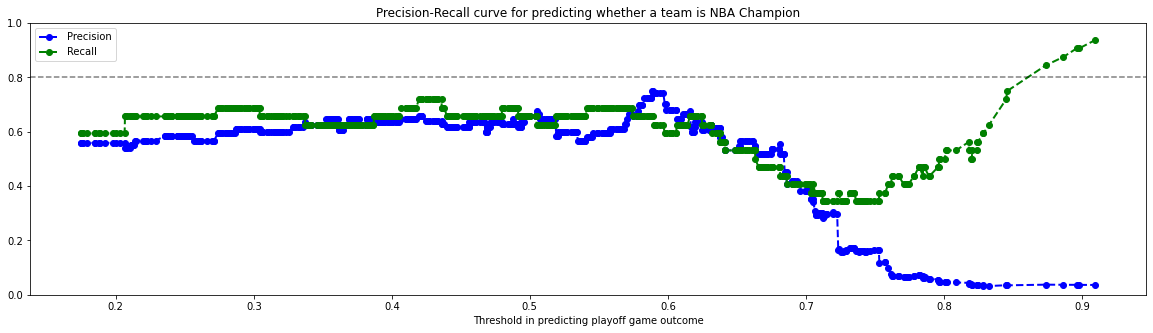

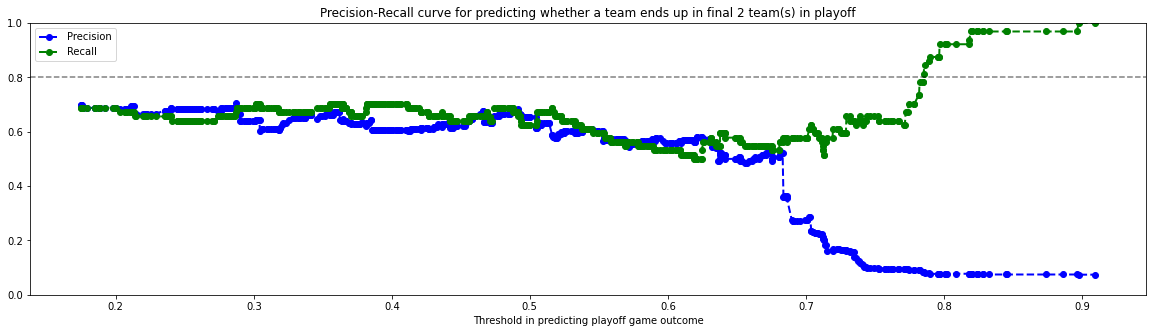

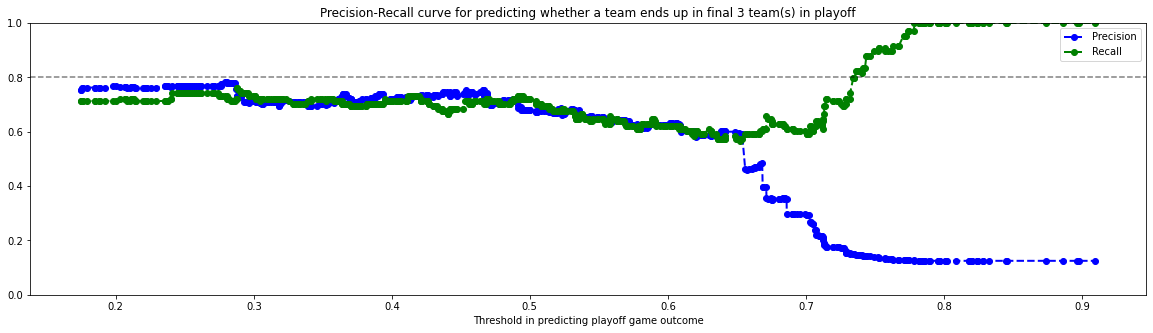

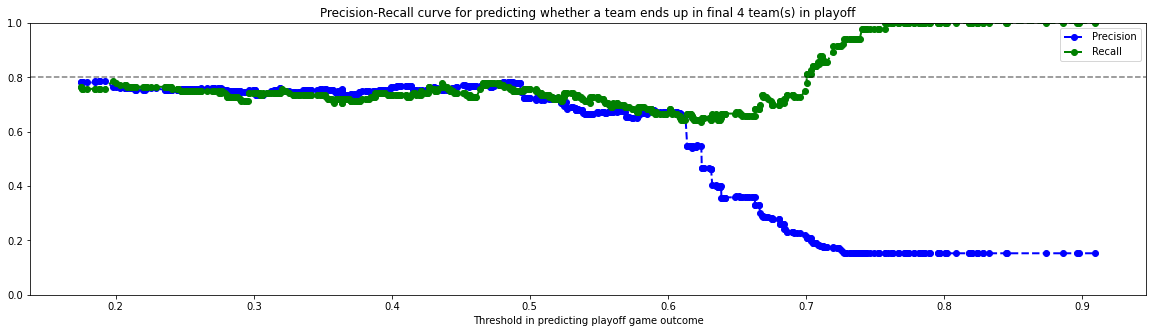

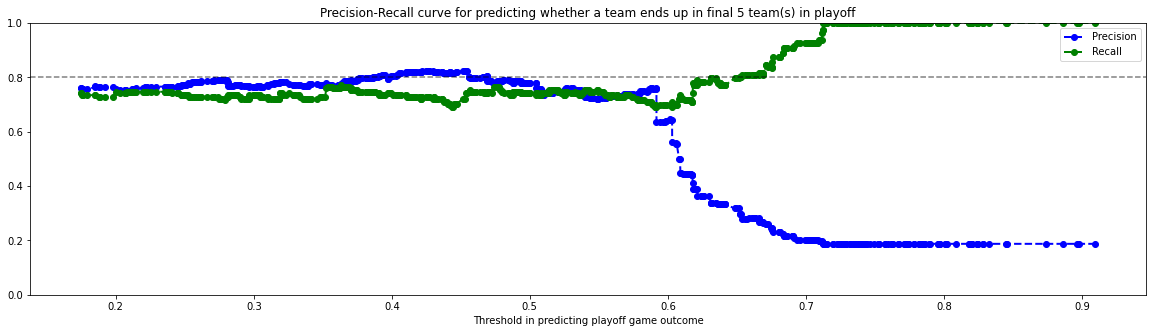

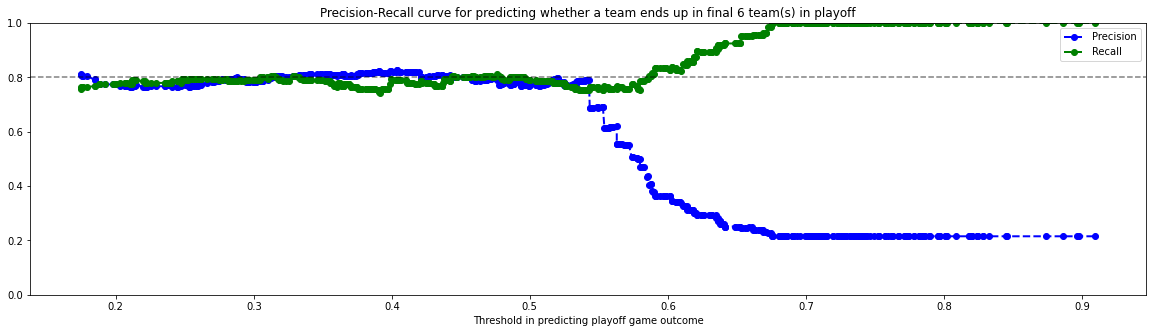

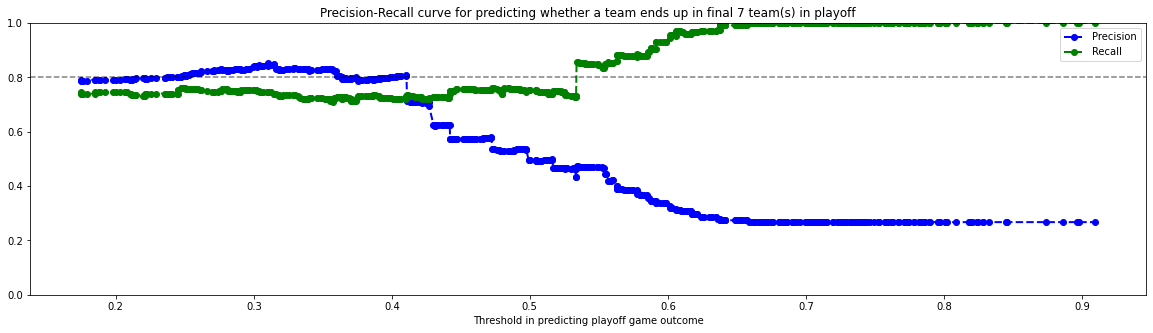

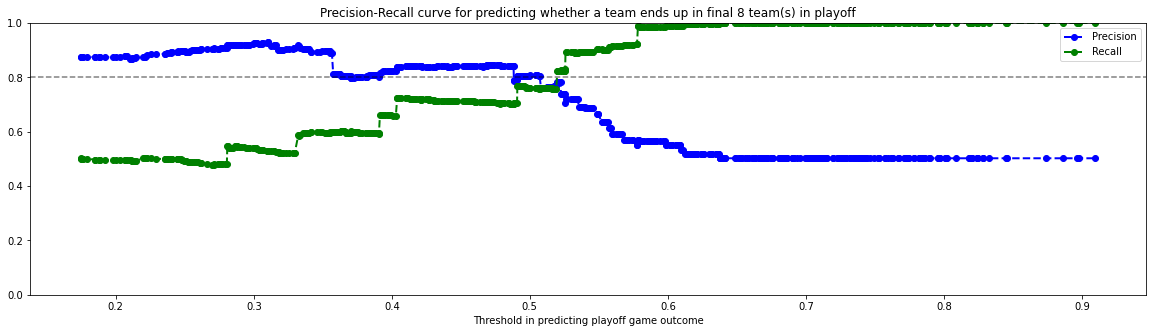

In [ ]:
# plot from NBA champion to final 8 teams
for i in range(1,9,1):
  playoff_ranking_diagnostics(i)

# Most probable champions in full dataset

In [ ]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_games_train_comprehensive.pkl?raw=true")

In [ ]:
full_set = pd.concat([train_set, test_set])

In [ ]:
X_full = full_set.drop(columns = "OUTCOME").reset_index(drop = True).copy(deep = True)
y_full = full_set[['OUTCOME']].copy()

In [ ]:
# playoff games which should have been won
most_probable = full_set.iloc[best_model.predict_proba(X_full)[:,1].argsort()[::-1],][['SEASON', 'GAME_DATE', 'MATCHUP', 'OUTCOME', 'HOME']]
most_probable['prob'] = sorted(best_model.predict_proba(X_full)[:,1], reverse=True)
most_probable.loc[most_probable['OUTCOME'] == 0].head(10)

,SEASON,GAME_DATE,MATCHUP,OUTCOME,HOME,prob
3710,2019-20,2020-08-18,MIL vs. ORL,0,1,0.886481
3204,2015-16,2016-04-18,OKC vs. DAL,0,1,0.840394
804,2001-02,2002-04-23,SAC vs. UTA,0,1,0.839878
4145,2021-22,2022-04-19,PHX vs. NOP,0,1,0.833093
3972,2020-21,2021-05-23,UTA vs. MEM,0,1,0.832683
2660,2012-13,2013-05-07,OKC vs. MEM,0,1,0.829266
2663,2012-13,2013-05-15,OKC vs. MEM,0,1,0.829266
3060,2015-16,2016-06-13,GSW vs. CLE,0,1,0.829253
3062,2015-16,2016-06-19,GSW vs. CLE,0,1,0.829253
522,1999-00,2000-05-15,IND vs. PHI,0,1,0.828573
